In [1]:
# !pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### **0. Data Load**


In [3]:
# 데이터 로드

train_path = '/root/dev/Ml_Team2_fork/1.Data/train.csv'
test_path  = '/root/dev/Ml_Team2_fork/1.Data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
# Data shape check

train.shape, test.shape

((1118822, 52), (9272, 51))

In [5]:
# train set variable check!

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [6]:
# train set missing value count

train.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

### **1. Data Pre-processing**

#### **1.0 Columns Rename**
> 복잡한 변수명 단순화

In [7]:
# 문자열 변경을 위한 re import
import re

key_list = {}

for text in list(train.columns):
    # '전용면적별세대현황'으로 시작하면 괄호 제거 안함
    if text.startswith('k-전용면적별세대'): # 그냥 괄호를 제거하면 중복된 이름이 발생하기 때문에 처리한 예외 처리 
        cleaned = re.sub(r'^k-', '', text).strip()

    else :
        cleaned = re.sub(r'\(.*?\)','',text)
        cleaned = re.sub(r'^k-','',cleaned)
        cleaned = cleaned.strip()
    key_list[text] = cleaned
print(key_list)

{'시군구': '시군구', '번지': '번지', '본번': '본번', '부번': '부번', '아파트명': '아파트명', '전용면적(㎡)': '전용면적', '계약년월': '계약년월', '계약일': '계약일', '층': '층', '건축년도': '건축년도', '도로명': '도로명', '해제사유발생일': '해제사유발생일', '등기신청일자': '등기신청일자', '거래유형': '거래유형', '중개사소재지': '중개사소재지', 'k-단지분류(아파트,주상복합등등)': '단지분류', 'k-전화번호': '전화번호', 'k-팩스번호': '팩스번호', '단지소개기존clob': '단지소개기존clob', 'k-세대타입(분양형태)': '세대타입', 'k-관리방식': '관리방식', 'k-복도유형': '복도유형', 'k-난방방식': '난방방식', 'k-전체동수': '전체동수', 'k-전체세대수': '전체세대수', 'k-건설사(시공사)': '건설사', 'k-시행사': '시행사', 'k-사용검사일-사용승인일': '사용검사일-사용승인일', 'k-연면적': '연면적', 'k-주거전용면적': '주거전용면적', 'k-관리비부과면적': '관리비부과면적', 'k-전용면적별세대현황(60㎡이하)': '전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)': '전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하': '85㎡~135㎡이하', 'k-135㎡초과': '135㎡초과', 'k-홈페이지': '홈페이지', 'k-등록일자': '등록일자', 'k-수정일자': '수정일자', '고용보험관리번호': '고용보험관리번호', '경비비관리형태': '경비비관리형태', '세대전기계약방법': '세대전기계약방법', '청소비관리형태': '청소비관리형태', '건축면적': '건축면적', '주차대수': '주차대수', '기타/의무/임대/임의=1/2/3/4': '기타/의무/임대/임의=1/2/3/4', '단지승인일': '단지승인일', '사용허가여부': '사용허가여부', '관리비 업로드': '관리비 업로드

In [8]:
train = train.rename(columns = key_list)
test = test.rename(columns = key_list)

#### **1.1 Data merge**

In [9]:
# Data pre-processing

## is_test : train/test 구분을 위한 변수
## concat을 통한 train, test 합쳐주기

train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['is_test'].value_counts())

(1128094, 53)
0    1118822
1       9272
Name: is_test, dtype: int64


In [10]:
# concat data set variable check!

concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   시군구                   1128094 non-null  object 
 1   번지                    1127867 non-null  object 
 2   본번                    1128019 non-null  float64
 3   부번                    1128019 non-null  float64
 4   아파트명                  1125958 non-null  object 
 5   전용면적                  1128094 non-null  float64
 6   계약년월                  1128094 non-null  int64  
 7   계약일                   1128094 non-null  int64  
 8   층                     1128094 non-null  int64  
 9   건축년도                  1128094 non-null  int64  
 10  도로명                   1128094 non-null  object 
 11  해제사유발생일               6195 non-null     float64
 12  등기신청일자                1128094 non-null  object 
 13  거래유형                  1128094 non-null  object 
 14  중개사소재지                1128094 non-nul

#### **1.1 Missing value**

In [11]:
# concat data set missing value count & missing value ratio check! 

from wcwidth import wcswidth

# 텍스트의 '보이는 너비'를 기준으로 왼쪽 정렬하여 공백을 채워주는 함수
def pad_str(text, total_width):
    """한글, 영문, 이모지가 섞인 문자열의 보이는 너비를 계산해 정렬합니다."""
    text_width = wcswidth(str(text)) # 어떤 타입이든 문자열로 변환
    padding_size = total_width - text_width
    return str(text) + ' ' * padding_size

In [12]:
COL_WIDTH = 35
DTYPE_WIDTH = 25
NUNIQUE_WIDTH = 18
MISSING_WIDTH = 18

# header print
print(f"{pad_str('📌 컬럼명', COL_WIDTH)}| {pad_str('데이터타입', DTYPE_WIDTH)}| {pad_str('고유값', NUNIQUE_WIDTH)}| {pad_str('결측개수', MISSING_WIDTH)}| 결측률")
print("-" * (COL_WIDTH + DTYPE_WIDTH + NUNIQUE_WIDTH + MISSING_WIDTH + 20)) # 구분선


# 열 전체를 넣고 스캔하기
for col in concat.columns[np.argsort(concat.isnull().sum())[::-1]]:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = str(concat.dtypes[col])
    
    # 각 정보 덩어리를 pad_str 함수로 감싸 정렬합니다.
    col_str = pad_str(f"📌 {col}", COL_WIDTH)
    dtype_str = pad_str(f"데이터타입: {col_type}", DTYPE_WIDTH)
    nunique_str = pad_str(f"고유값: {nunique}", NUNIQUE_WIDTH)
    missing_str = pad_str(f"결측개수: {missing_count}", MISSING_WIDTH)

    print(f"{col_str}| {dtype_str}| {nunique_str}| {missing_str}| {missing_ratio:.2%}")


📌 컬럼명                          | 데이터타입               | 고유값            | 결측개수          | 결측률
--------------------------------------------------------------------------------------------------------------------
📌 135㎡초과                       | 데이터타입: float64      | 고유값: 2         | 결측개수: 1127765 | 99.97%
📌 해제사유발생일                  | 데이터타입: float64      | 고유값: 1034      | 결측개수: 1121899 | 99.45%
📌 등록일자                        | 데이터타입: object       | 고유값: 128       | 결측개수: 1116386 | 98.96%
📌 단지소개기존clob                | 데이터타입: float64      | 고유값: 95        | 결측개수: 1058958 | 93.87%
📌 홈페이지                        | 데이터타입: object       | 고유값: 222       | 결측개수: 1013523 | 89.84%
📌 고용보험관리번호                | 데이터타입: object       | 고유값: 527       | 결측개수: 920757  | 81.62%
📌 세대전기계약방법                | 데이터타입: object       | 고유값: 3         | 결측개수: 885389  | 78.49%
📌 팩스번호                        | 데이터타입: object       | 고유값: 1386      | 결측개수: 879348  | 77.95%
📌 시행사                          | 데이터타입: object     

> 1. 결측치 비율을 확인하니 70%이상 결측치로 채워져있는 변수가 상당 수인 것을 확인 할 수 있음
> 2. 결측치를 imputation하여 사용하기에는 30% 이상 결측인 변수가 많아 상당 수의 변수를 사용할 수 없을 것으로 생각됨

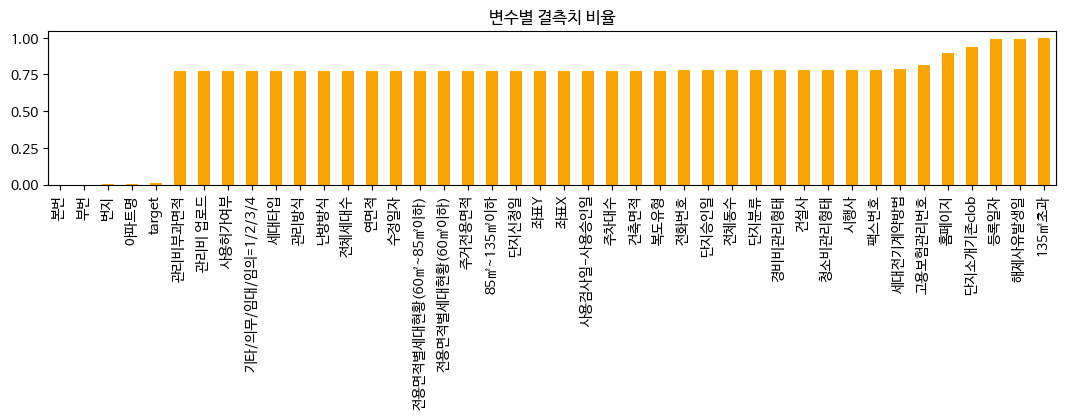

In [13]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

> 결측 비율이 30%가 넘어가는 변수들은 실질적으로 사용하기에는 무리가 있기 때문에 결측률이 30%가 넘어가는 변수 모두 삭제

In [14]:
# 결측률이 30% 이상인 변수 삭제
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))

✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['해제사유발생일', '단지분류', '전화번호', '팩스번호', '단지소개기존clob', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [15]:
# 결측률 30% 이상 변수 삭제
concat.drop(columns = list(concat.columns[concat.isnull().sum()/concat.shape[0]  >= 0.3]), axis = 1, inplace = True)

In [16]:
# categorical column name, numerical column name return function
def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

In [17]:
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']


In [18]:
# 결측치는 아닌데 의미 없는 형식적 값 찾는 함수

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            val_counts = df[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64



In [19]:
# 아무 의미 없는 값 결측처리를 위해 nan으로 변경
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [20]:
# 결측률이 30% 이상인 변수 확인
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))

✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['등기신청일자', '거래유형', '중개사소재지']


In [21]:
# 결측률 30% 이상 삭제
concat.drop(axis = 1, columns = list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]), inplace=True)

In [22]:
# update and check variable
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']


##### 번외. **시간관련 변수들 살펴보기 (1. 계약년월)**

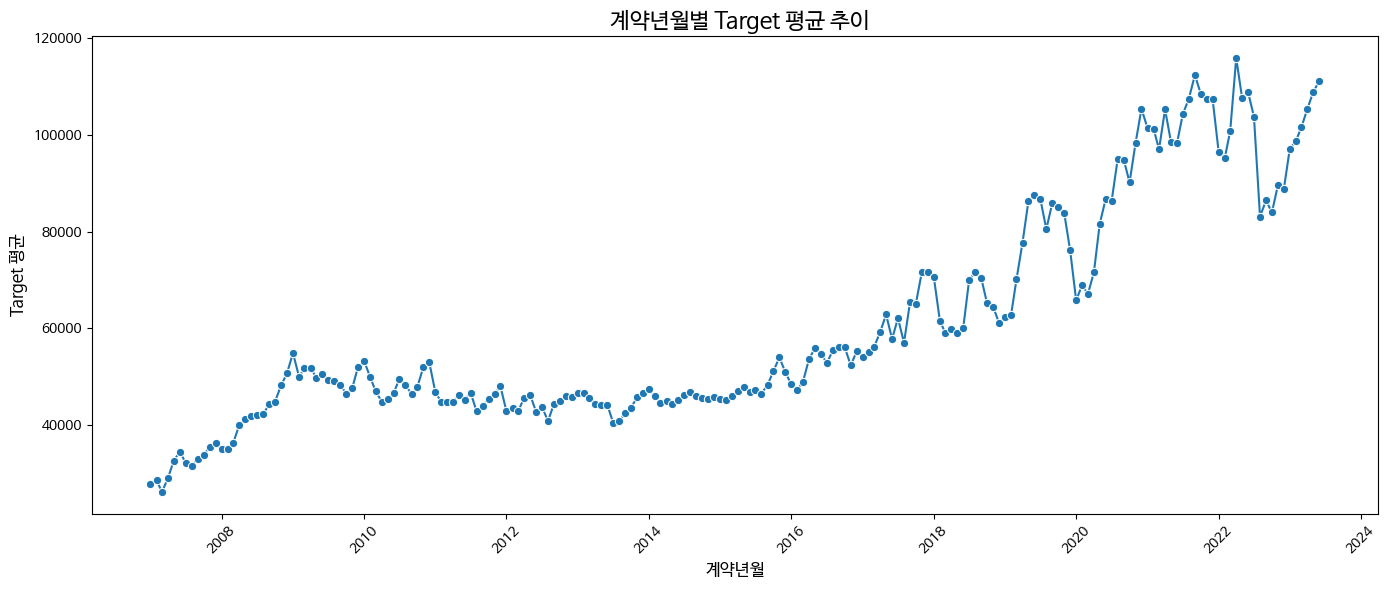

In [23]:
# 계약년월 예: 201806 
# concat['계약년월'] = pd.to_datetime(concat['계약년월'].astype(str), format="%Y%m")

# 시계열 기준 groupby 평균
monthly_mean = concat.groupby('계약년월')['target'].mean().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")


# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_mean, x='계약년월', y='target', marker='o')

# 제목과 라벨 꾸미기
plt.title('📈 계약년월별 Target 평균 추이', fontsize=16)
plt.xlabel('계약년월', fontsize=12)
plt.ylabel('Target 평균', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> 1. 계약년월에 따른 집값은 우상향 추세가 있는 것으로 보여짐
> 2. 2008년 12월과 2009년 1월에 차이는 실제로 한달이지만 모형에 정수형으로 input값이 들어가게 된다면 89에 숫자차이가 발생
> 3. 이를 해결하기 위한 방안
>> 1. 계약 년, 월을 구분하여 파생변수를 생성하여 범주화 -> 시간에 흐름에 따른 증가를 반영하지 못하게 될 수도 있음
>> 2. 계약 년만 따로 변수로 생성 -> seanality가 있을 시 반영 못할 수도 있음
>> 3. 계약년월을 int형태로 변화하여 2008년에서 2009년으로 넘어가는 해가 넘어가는 시점의 차이를 없애기 ✅ 제일 먼저 고려해볼만 함
> 4. 계약년월에서 월에 해당하는 부분이 계절성이 있는지를 살펴볼 필요가 있음 -> 계절성이 있다면 월마다 범주 처리 없다면 정수처리

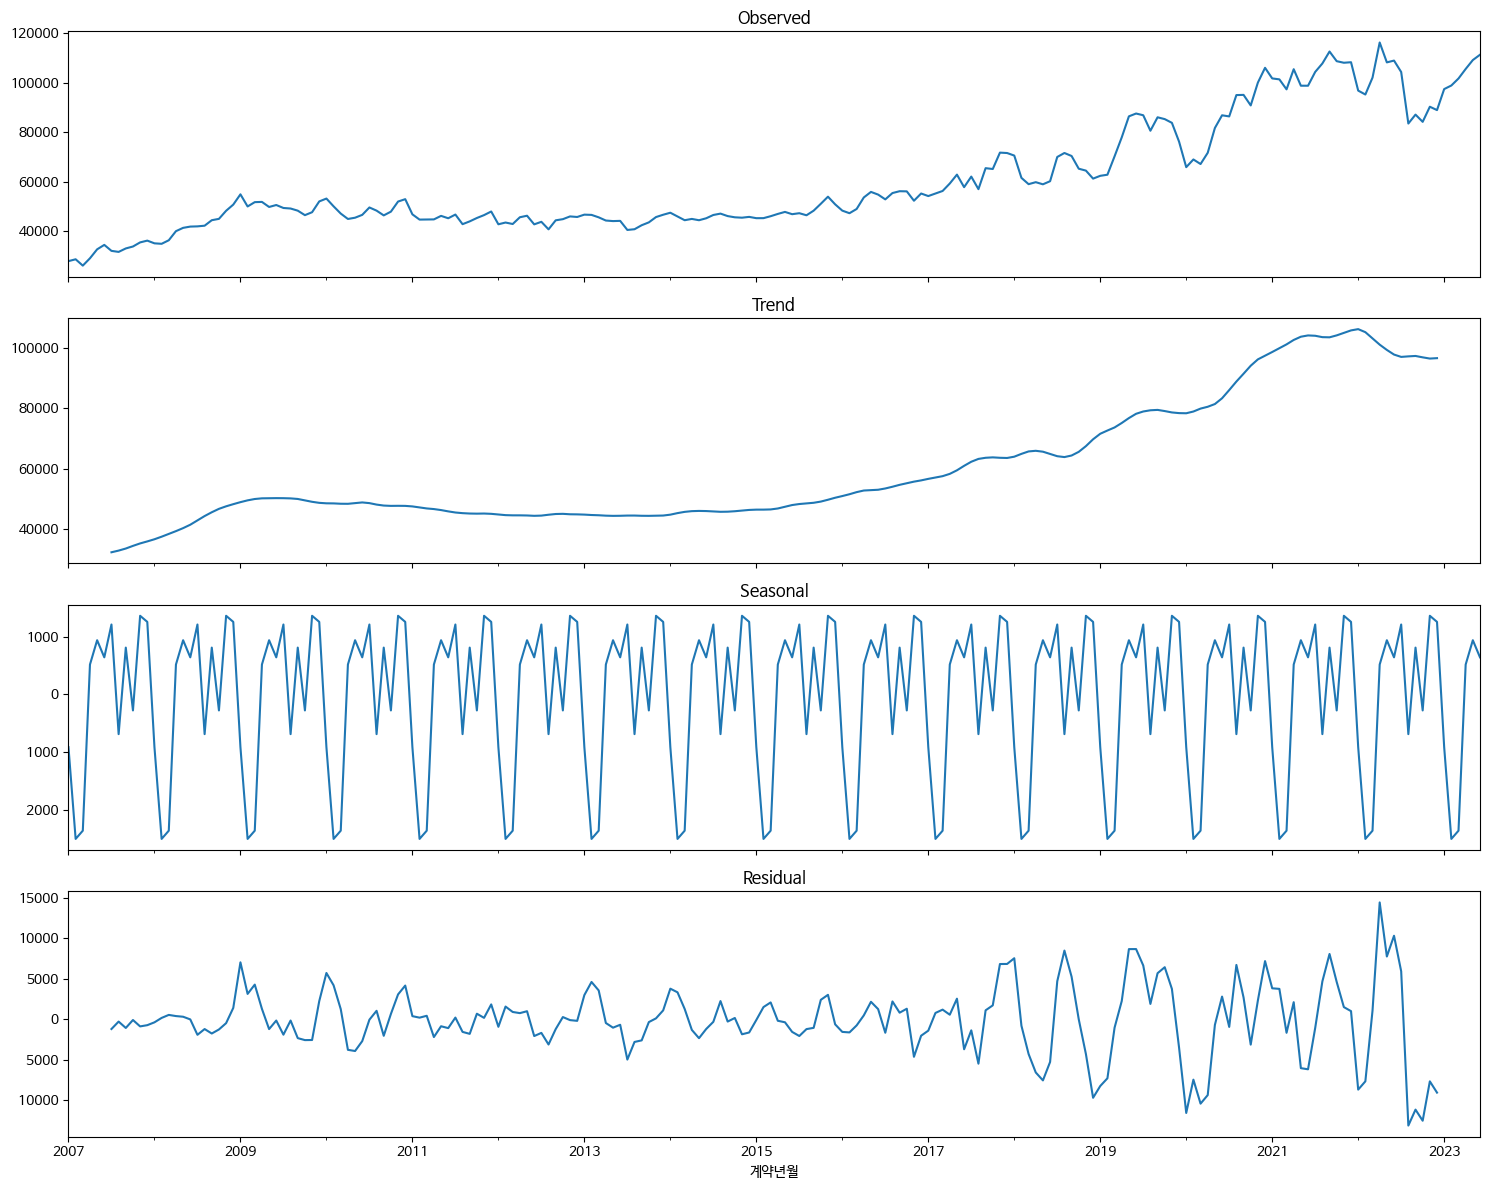

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

monthly_mean = concat.dropna().groupby('계약년월')['target'].mean().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")

monthly_mean_ts = monthly_mean.set_index('계약년월')['target']

decomposition = seasonal_decompose(monthly_mean_ts, model='additive', period=12);

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
observed = decomposition.observed

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

observed.plot(ax=axs[0], title='Observed')
trend.plot(ax=axs[1], title='Trend')
seasonal.plot(ax=axs[2], title='Seasonal')
resid.plot(ax=axs[3], title='Residual')

plt.tight_layout()
plt.show()


**시계열분석 결과해석**
|구성요소|해석|
|-----|----------------------------------------|
|Trend|2015년 이후 정도부터 추세선이 상승, 2019 ~ 2021 급등, 2022년 부터 꺾임
|Seasonal|명확한 계절성 존재(봄-가을 상승, 겨울 하락)
|Residual|2020년 이후 residual이 매우 커짐 외부 충격으로 생각됨(코로나, 정책 등)


<br>

=================================================

**위 같은 결과해석으로 인해 생각 할 수 있는 파생변수**

> 1. 계약시간 201812, 201901의 수치적 차이는 약 90의 달함 이 같은 수치적차이를 월에 해당하는 부분을 12로 나누어 해결
> 2. 계약월 : 1 ~ 12월을 범주형
> 3. 계절 : 봄 여름 가을 겨울 범주형
> 4. 특정이벤트 여부 반영 : 코로나 2020.01 이후 이전, 특정 정책 이후 이전

##### 번외. **시간관련 변수들 살펴보기 (1. 계약년월)** - 파생변수 만들기

In [ ]:
# 파생변수 만들기 
concat['contract_year'] = concat['계약년월'] // 100 # 계약년도
concat['contract_month'] = concat['계약년월'] % 100 # 계약월
concat['contract_date'] = concat['contract_year'] + concat['contract_month'] / 12 # 계약시간

def get_season(month):
    if month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'fall'
    else : 
        return 'winter'
concat['season'] = concat['contract_month'].apply(get_season) # 계약계절
concat['covid'] = (concat['계약년월'] >= 202001).astype(int) # 코로나 시기 구분

concat['contract_month_sin'] = np.sin(2 * np.pi * concat['contract_month'] / 12)
concat['contract_month_cos'] = np.cos(2 * np.pi * concat['contract_month'] / 12)

In [64]:
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,target,is_test,apt_age,new_old,contract_year,contract_month,contract_date,season
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,124000.0,0,38,old,2017,12,2018.000000,winter
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,123500.0,0,38,old,2017,12,2018.000000,winter
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,91500.0,0,38,old,2017,12,2018.000000,winter
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,130000.0,0,38,old,2018,1,2018.083333,winter
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,117000.0,0,38,old,2018,1,2018.083333,winter


##### 번외. **시간관련 변수들 살펴보기 (2. 계약일)**

<Axes: xlabel='계약일', ylabel='target'>

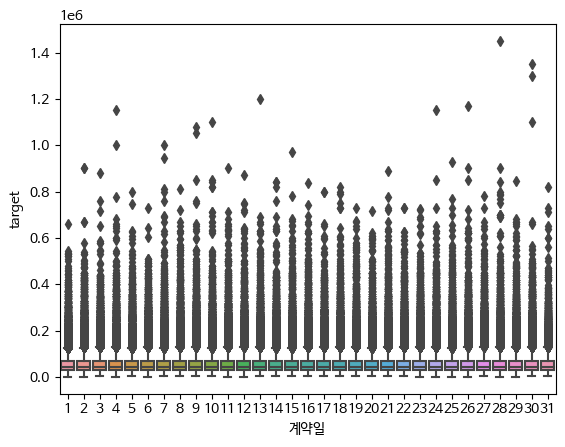

In [24]:
temp = concat.sort_values('계약일')
sns.boxplot(x = temp['계약일'].astype('str'), y = temp['target'])

In [25]:
from scipy.stats import levene, f_oneway

# 임시 결측행 제거
temp = concat.dropna()

# 지역별 그룹 나누기
groups = [group['target'].values for name, group in temp.groupby('계약일')]

# 등분산 검정
stat, p = levene(*groups)
print(f"📊 Levene 등분산 검정 통계량: {stat:.4f}, p-value: {p:.4f}")

# ANOVA 검정
stat, p = f_oneway(*groups)
print(f"📊 F-statistic: {stat:.4f}, p-value: {p:.4f}")

📊 Levene 등분산 검정 통계량: 4.4625, p-value: 0.0000
📊 F-statistic: 6.9263, p-value: 0.0000


> 그룹간 Levene 등분산 검정과 ANOVA를 통해 분포에는 차이가 없는 것으로 보여진다.
> 즉 일자별로 집값의 가격이 다르다고 할 수 없기 때문에 해당 변수는 집값의 영향력이 작다고 할 수 있다.

##### 번외. **시간관련 변수들 살펴보기 (3. 건축년도)**

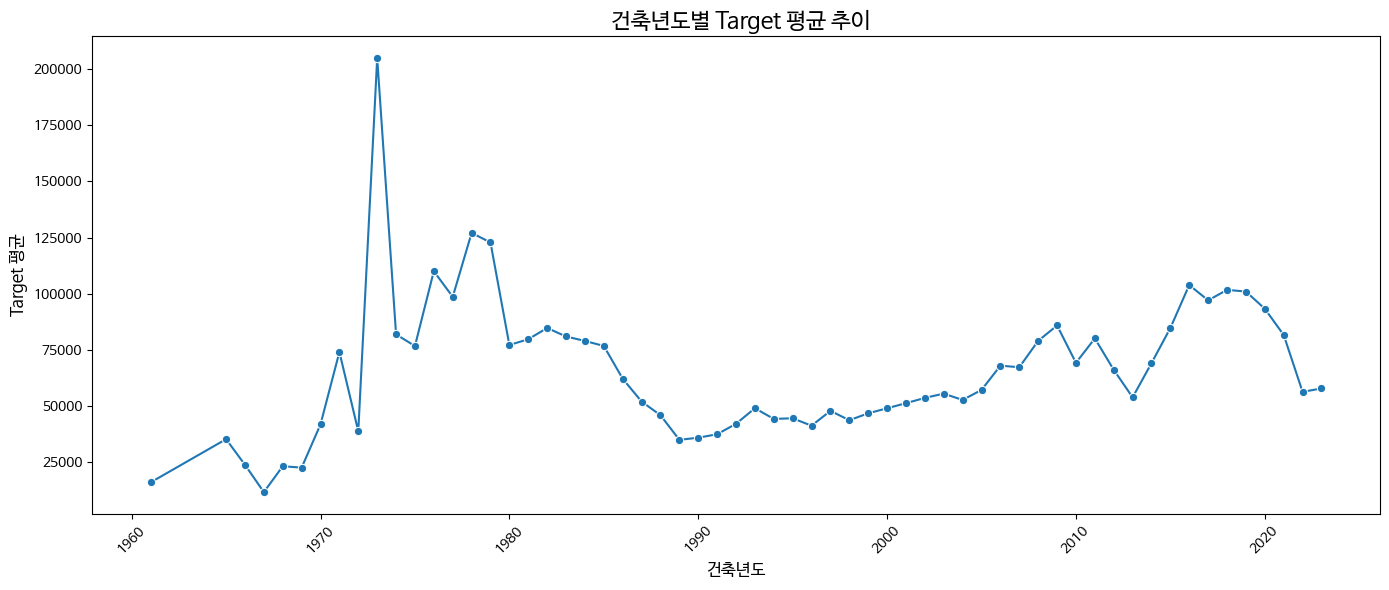

In [26]:
# 건축년도: 1961, 2023
# concat['건축년도'] = pd.to_datetime(concat['건축년도'].astype(str), format="%Y%m")

# 시계열 기준 groupby 평균
construct_year_mean = concat.groupby('건축년도')['target'].mean().reset_index()
construct_year_mean['건축년도'] = pd.to_datetime(construct_year_mean['건축년도'].astype(str), format="%Y")


# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=construct_year_mean, x='건축년도', y='target', marker='o')

# 제목과 라벨 꾸미기
plt.title('📈 건축년도별 Target 평균 추이', fontsize=16)
plt.xlabel('건축년도', fontsize=12)
plt.ylabel('Target 평균', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

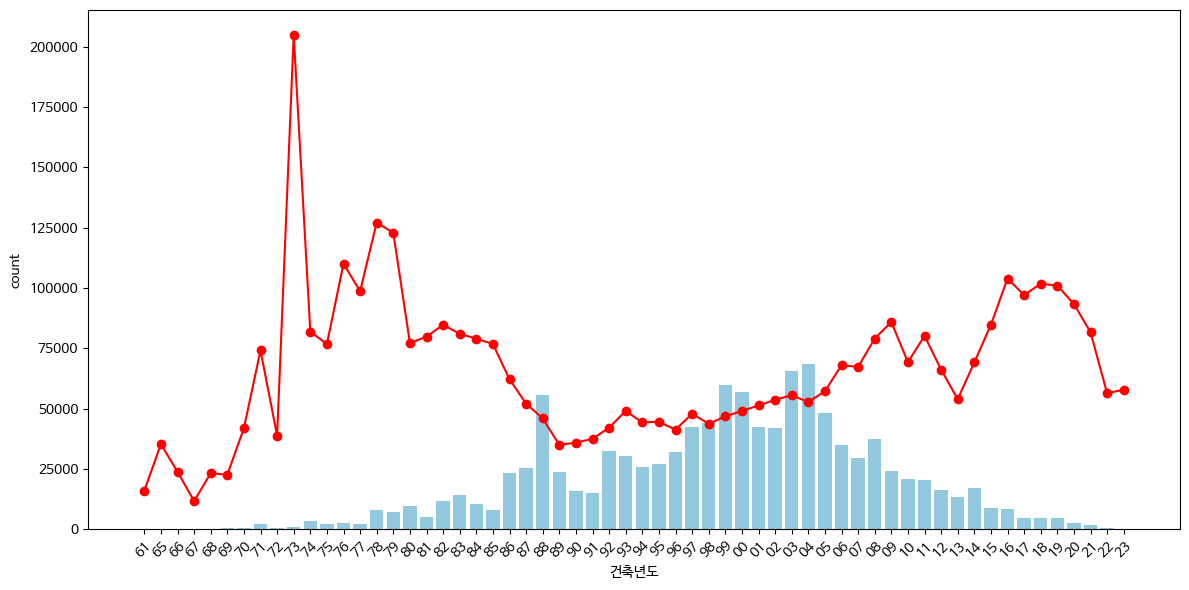

In [27]:
temp = concat.groupby('건축년도')['target'].agg(['count','mean'])

plt.figure(figsize = (12,6))
sns.barplot(data = temp, x = temp.index, y = 'count', color = 'skyblue')

plt.plot(range(len(temp.index)), temp['mean'], color='red', marker='o', label='평균 집값')

plt.xticks(
    ticks=range(len(temp.index)), 
    labels=[str(x)[-2:] for x in temp.index], 
    rotation=45,
    fontsize = 10
);
plt.tight_layout()
plt.show()

In [28]:
mini = min(concat[concat['건축년도'] == 1973]['target'])
maxi = max(concat[concat['건축년도'] == 1973]['target'])
num = len(concat[concat['건축년도'] == 1973]['target'])


print(f'1973년도 건축된 건물 가격 최대 : {maxi}, 최소 : {mini}, 거래 수 : {num}')

1973년도 건축된 건물 가격 최대 : 730000.0, 최소 : 8000.0, 거래 수 : 1049


In [29]:
concat[concat['건축년도'] == 1973]['아파트명'].value_counts()

반포주공1단지     780
역촌맨션         79
광산           56
동대문맨션        35
주미           34
타워맨션         29
뉴후암          22
남산힐레지던스       7
유엔맨숀          4
사직파크맨션        2
201호 미공시      1
Name: 아파트명, dtype: int64

>* 1989년을 기점으로 집값의 추세가 변화하는 것을 알 수 있다. 
>* 1989년을 기점으로 더 오래된 건물을 연식이 오래된 건물 89년 이후를 나름 신식인 건물로 표기하는 파생변수를 만들면 좋을듯
>* 1973년에 이상하게 주택거래양이 적은데 불구하고 평균가격이 치솟고 있는 것을 확인 할 수 있다. 이는 board에 작성글이 무슨 이상치가 있을까에 있는 내용으로 1973년 당시 3590세대로 지어진 대규모 아파트로서, 단지가 당시 매우 큰 대규모 아파트 이며, 서초구 반포동이라는 부촌 특성상 높은 가격에 거래하였기 때문에 평균이 함께 증가한 사례라고 볼 수 있다. 
>* 1973년을 binning하는것도 좋은 선택지가 될 수 있을 것으로 보여짐

##### 번외. **시간변수 관련(3. 건축년도)** - 파생변수 만들기

In [30]:
# 빌딩의 나이
current = 2025
concat['apt_age'] = current - concat['건축년도']

# 연식 구분 89년이전 old, 90년이후 new
concat['new_old'] = ['old' if 1989 >= i else 'new' for i in concat['건축년도']]

In [34]:
# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명', 'new_old']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test', 'apt_age']


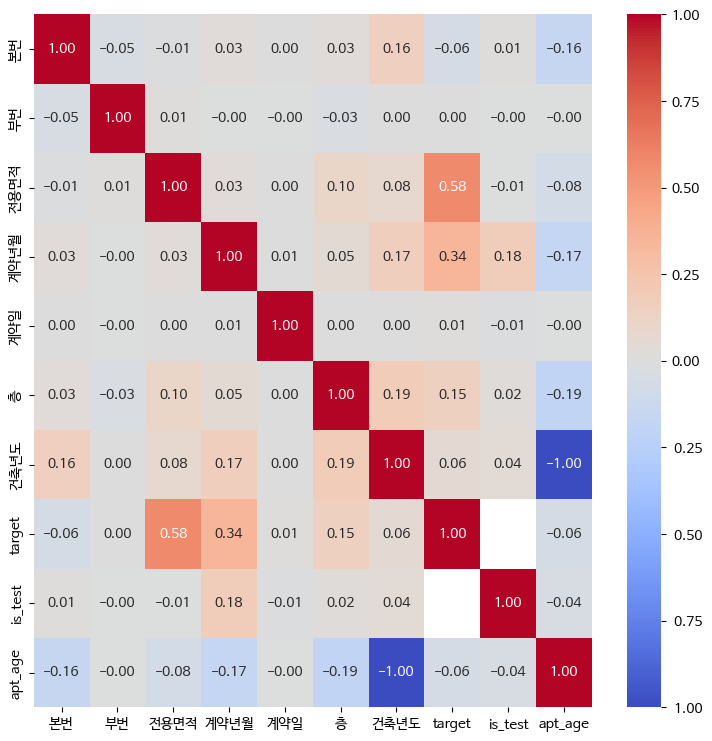

In [39]:
plt.figure(figsize = (9,9))

sns.heatmap(concat[num_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

> 건축년도와 새로만든 파생변수인 아파트나이변수가 상관계수가 -1이므로 둘 중 하나를 삭제하겠다. 새로 만든 건축년도를 제거

In [66]:
concat.drop(axis = 1, columns = ['건축년도'], inplace = True)
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,도로명,target,is_test,apt_age,new_old,contract_year,contract_month,contract_date,season,covid
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,언주로 3,124000.0,0,38,old,2017,12,2018.000000,winter,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,언주로 3,123500.0,0,38,old,2017,12,2018.000000,winter,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,언주로 3,91500.0,0,38,old,2017,12,2018.000000,winter,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,언주로 3,130000.0,0,38,old,2018,1,2018.083333,winter,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,언주로 3,117000.0,0,38,old,2018,1,2018.083333,winter,0


In [68]:
concat['구'] = list(map(lambda x : x.split(' ')[1],concat['시군구']))
concat['동'] = list(map(lambda x : x.split(' ')[2],concat['시군구']))

In [70]:
concat.drop(axis = 1, columns= ['시군구'], inplace = True)

In [72]:
# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['번지', '아파트명', '도로명', 'new_old', 'season', '구', '동']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', 'target', 'is_test', 'apt_age', 'contract_year', 'contract_month', 'contract_date', 'covid']


##### 제거 변수

> * 번지, 아파트명, 도로명, 본번, 부번은 큰 의미가 없어 보이는 변수이므로 제거
> * 계약년월은 파생변수로 이미 표현이 충분히 되므로 삭제
> * 계약일은 분석 결과 큰 영향을 주지 않는것으로 생각되어 삭제

In [ ]:
drop_list = ['번지', '아파트명', '도로명', '본번', '부번', '계약년월', '계약일', 'contract_year', 'contract_month']
concat.drop(axis = 1, columns= drop_list, inplace=True)
# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['new_old', 'season', '구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'is_test', 'apt_age', 'contract_date', 'covid', 'contract_month_sin', 'contract_month_cos']


In [85]:
concat.isnull().sum()

전용면적                     0
층                        0
target                9272
is_test                  0
apt_age                  0
new_old                  0
contract_date            0
season                   0
covid                    0
구                        0
동                        0
contract_month_sin       0
contract_month_cos       0
dtype: int64

### 2. Modeling

In [86]:
# train set, test set split
df_train = concat.query('is_test == 0')
df_test = concat.query('is_test == 1')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_test'], axis = 1, inplace=True)
df_test.drop(['is_test'], axis = 1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 12) (9272, 12)


> 총 11개의 변수를 가지고 학습

In [87]:
cat_cols, num_cols = split_categorical_numerical(df_train)
# covid와

📌 범주형 변수: ['new_old', 'season', '구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'apt_age', 'contract_date', 'covid', 'contract_month_sin', 'contract_month_cos']


In [88]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( cat_cols ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


In [89]:
df_train.head()

,전용면적,층,target,apt_age,new_old,contract_date,season,covid,구,동,contract_month_sin,contract_month_cos
0,79.97,3,124000.0,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
1,79.97,4,123500.0,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
2,54.98,5,91500.0,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
3,79.97,4,130000.0,38,1,2018.083333,3,0,0,8,5.000000e-01,0.866025
4,79.97,2,117000.0,38,1,2018.083333,3,0,0,8,5.000000e-01,0.866025


In [90]:
assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y_train = np.log1p(df_train['target'])
X_train = df_train.drop(['target'], axis=1)

In [ ]:
X_train.head()

,전용면적,층,apt_age,new_old,contract_date,season,covid,구,동,contract_month_sin,contract_month_cos
0,79.97,3,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
1,79.97,4,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
2,54.98,5,38,1,2018.000000,3,0,0,8,-2.449294e-16,1.000000
3,79.97,4,38,1,2018.083333,3,0,0,8,5.000000e-01,0.866025
4,79.97,2,38,1,2018.083333,3,0,0,8,5.000000e-01,0.866025


In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import time



In [97]:
# 모델 객체 생성
rf = RandomForestRegressor(criterion='squared_error',random_state=42, n_jobs=-1)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100],         # 작게 설정해 시간 단축
    'max_depth': [10, 20],             # 너무 깊은 트리는 과적합 우려 + 느림
    'max_features': ['sqrt', 0.8],     # 'sqrt'는 일반적으로 좋은 성능
}


start = time.time()

# Do GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs= -1,
    verbose = 2
)

end = time.time()
print(f"⏱ 실행 시간: {end - start:.2f}초")

# model fitting
grid_search.fit(X_train,y_train)



# result printting
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최적 RMSE (cv 평균):", -grid_search.best_score_)

⏱ 실행 시간: 0.00초
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time= 1.0min
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time= 1.1min
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time= 1.1min
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time= 1.1min
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time= 1.1min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time= 1.9min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time= 1.9min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time= 1.9min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time= 2.0min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time= 2.0min
[CV] END ....max_depth=10, max_features=0.8, n_estimators=50; total time= 2.2min
[CV] END ....max_depth=10, max_features=0.8, n_estimators=50; total time= 2.3min
[CV] END ....max_depth=10, m

In [99]:
df_test.drop(columns=['target'], axis = 1, inplace=True)

In [103]:
model = grid_search.best_estimator_

pred = np.expm1(model.predict(df_test))



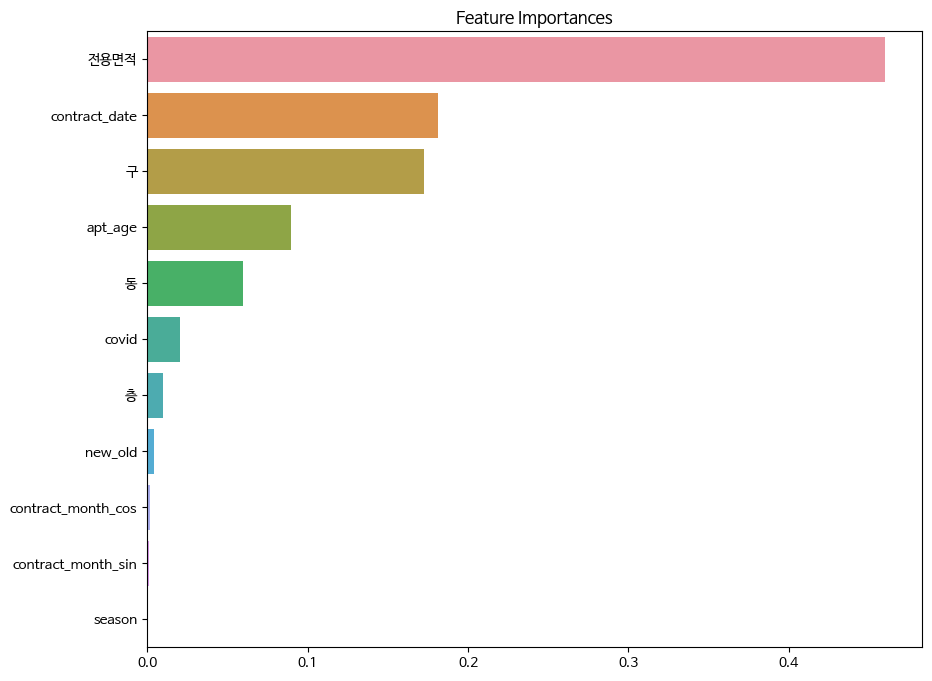

In [105]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [106]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('/root/dev/Ml_Team2_fork/1.Data/rm_var_log_gs_rf_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [107]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('/root/dev/Ml_Team2_fork/4.Submission/submission_0716.csv', index=False)